# Importing libraries

In [1]:
import opendatasets as od #for downloading dataset from kaggle
import pandas as pd #for data manipulation
import numpy as np #for numerical operations
import os #for path(directories,files,etc)
import matplotlib.pyplot as plt #for graphs
import cv2 #for image processing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator #To perfrom data augumentation
from tensorflow.keras.preprocessing import image_dataset_from_directory 

# Download Dataset

In [2]:
od.download("https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: eswarpavanmaganti
Your Kaggle Key: ········


100%|███████████████████████████████████████████████████████████████████████████████| 330M/330M [04:03<00:00, 1.42MB/s]


# Downloaded Dataset(path)

In [3]:
dataset_dir = r"C:\Users\eswar\Downloads\base_cnn\face-mask-12k-cnn\face-mask-12k-images-dataset\Face Mask Dataset"
train_dir = r"C:\Users\eswar\Downloads\base_cnn\face-mask-12k-cnn\face-mask-12k-images-dataset\Face Mask Dataset\Train"
test_dir = r"C:\Users\eswar\Downloads\base_cnn\face-mask-12k-cnn\face-mask-12k-images-dataset\Face Mask Dataset\Test"
val_dir = r"C:\Users\eswar\Downloads\base_cnn\face-mask-12k-cnn\face-mask-12k-images-dataset\Face Mask Dataset\Validation"

# Dataset Visualization

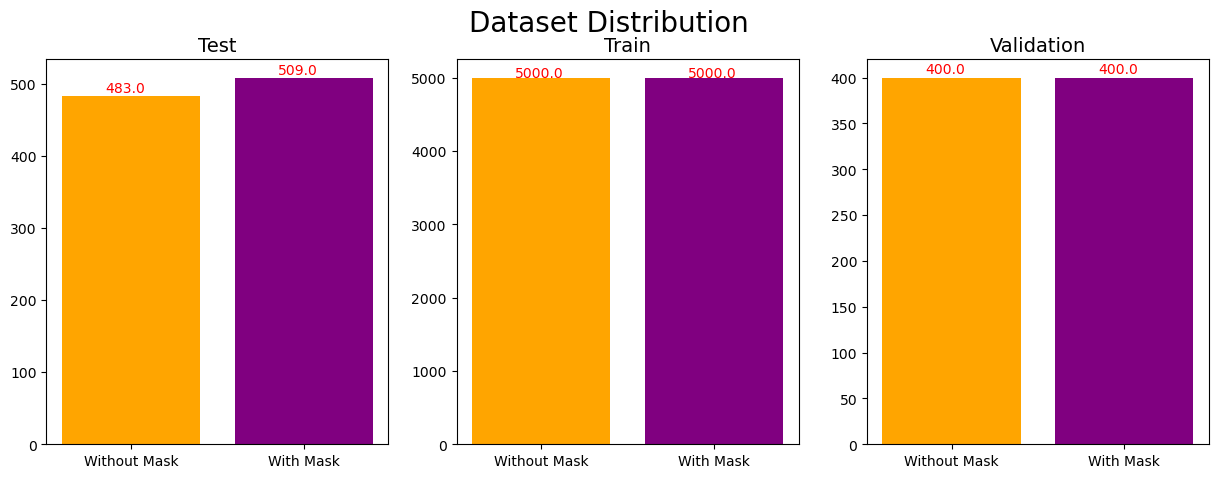

In [4]:
Classes=['Without Mask' , 'With Mask']
figure, axes = plt.subplots(1, 3, figsize=(15,5)) #plot graph in 1 row and 3 columns
for i in os.listdir(dataset_dir):
    total=[]
    ax = axes[os.listdir(dataset_dir).index(i)]
    for ct in os.listdir(dataset_dir+'/'+i):
        count=len(os.listdir(dataset_dir+'/'+i+'/'+ct))
        total.append(count)
    ax.bar(Classes, total, color=['orange' , 'purple'])
    ax.set_title(i,size=14)
    for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()),(p.get_x()+0.25, p.get_height()+5), color='r')
plt.suptitle('Dataset Distribution',size=20)
plt.show()

# Loading Data

In [5]:
def load_data():
    data = []
    labels = []
    for category in os.listdir(dataset_dir):
        category_dir = os.path.join(dataset_dir, category)
        for subcategory in os.listdir(category_dir):
            subcategory_dir = os.path.join(category_dir, subcategory)
            for img in os.listdir(subcategory_dir):
                img_path = os.path.join(subcategory_dir, img)
                img_array = cv2.imread(img_path)
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) #BGR TO RGB
                img_array = cv2.resize(img_array, (96,96)) #resize images
                data.append(img_array)
                labels.append(subcategory)
    data=np.array(data)
    labels=np.array(labels)
    return data,labels
data,labels = load_data()

# Data Preprocessing and Data augumentation

In [6]:
#Normalize the data
data = data.astype("float32")/255.0
#Dataset augumentation
train_datagen = ImageDataGenerator(
                                 rescale = 1./255,
                                 fill_mode = 'nearest',
                                 height_shift_range = 0.2,
                                 horizontal_flip = True,
                                 vertical_flip=True,
                                 zoom_range = 0.25,
                                 width_shift_range = 0.2,
                                 rotation_range = 10.0,)

Train_dataset_gen = train_datagen.flow_from_directory(train_dir,
                                             batch_size=16,
                                             class_mode='categorical',
                                             color_mode="rgb",
                                             shuffle=True,
                                             seed=32,
                                             target_size=(96,96))


Found 10000 images belonging to 2 classes.


# Test Data Augumentation

In [7]:
test_datagen = ImageDataGenerator(rescale = 1./255)

Test_dataset_gen = test_datagen.flow_from_directory(test_dir,
                                             batch_size=16,
                                             class_mode='categorical',
                                             color_mode="rgb",
                                             shuffle=False,
                                             target_size=(96,96))

Validation_dataset_gen = test_datagen.flow_from_directory(val_dir,
                                             batch_size=16,
                                             class_mode='categorical',
                                             color_mode="rgb",
                                             shuffle=False,
                                             target_size=(96,96))

Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [8]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Activation,Flatten,Dropout

In [9]:
n_class = 2 # Number of classes --> With_Mask, Without_Mask

# MODELBUILDING

In [10]:
# Build Model
#layer by Layer Model
model = models.Sequential()
# 1st layer
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(96,96,3)))
model.add(MaxPooling2D((2, 2)))
# 2nd  layer
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
# 3rd Conv layer
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
# 4th Conv layer
model.add(Conv2D(96, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
# 5th Conv layer
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
# convert the 5th layer to one dimensional array
model.add(Flatten())
#Fully connected layer with 1024 units
model.add(Dense(1024))
#Regulation Technique to prevent overfitting
model.add(Dropout(0.2))
#Fully connected layer with 64 units
model.add(Dense(64))
#Regulation Technique to prevent overfitting
model.add(Dropout(0.2))
#Fully connected layer with n_class =2 units
model.add(Dense(n_class, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

# MODEL COMPILING

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='Adam',  metrics=['accuracy'])

In [12]:
num_epochs = 50

# MODEL TRAINING

In [13]:
# Train Model
Train_model=model.fit(Train_dataset_gen,steps_per_epoch=(Train_dataset_gen.n//Train_dataset_gen.batch_size),epochs=num_epochs, 
                      validation_data=Validation_dataset_gen, validation_steps=(Validation_dataset_gen.n//Validation_dataset_gen.batch_size))

Epoch 1/50
625/625 [==============================] - 37s 57ms/step - loss: 0.2905 - accuracy: 0.8859 - val_loss: 0.2195 - val_accuracy: 0.9225
Epoch 2/50
625/625 [==============================] - 36s 57ms/step - loss: 0.2127 - accuracy: 0.9246 - val_loss: 0.1625 - val_accuracy: 0.9488
Epoch 3/50
625/625 [==============================] - 36s 58ms/step - loss: 0.1902 - accuracy: 0.9309 - val_loss: 0.2628 - val_accuracy: 0.9062
Epoch 4/50
625/625 [==============================] - 39s 63ms/step - loss: 0.1914 - accuracy: 0.9326 - val_loss: 0.1048 - val_accuracy: 0.9638
Epoch 5/50
625/625 [==============================] - 37s 59ms/step - loss: 0.1653 - accuracy: 0.9414 - val_loss: 0.0803 - val_accuracy: 0.9737
Epoch 6/50
625/625 [==============================] - 37s 60ms/step - loss: 0.1590 - accuracy: 0.9444 - val_loss: 0.0809 - val_accuracy: 0.9700
Epoch 7/50
625/625 [==============================] - 36s 57ms/step - loss: 0.1503 - accuracy: 0.9477 - val_loss: 0.1009 - val_accuracy:

In [14]:
models.save_model(model, "facemask_model.h5")

# Test Loss and Test Accuracy

In [15]:
loss, acc = model.evaluate(Test_dataset_gen, steps=(Test_dataset_gen.n//Test_dataset_gen.batch_size))
print("The accuracy of the model is {:.2f}\nThe Loss in the model is {:.3f}".format(acc*100,loss))

62/62 [==============================] - 4s 72ms/step - loss: 0.0367 - accuracy: 0.9940
The accuracy of the model is 99.40
The Loss in the model is 0.037


# Confusion Matrix

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
p=model.predict(Test_dataset_gen)
y_pred = np.argmax(p,axis=1)
y_actual = Test_dataset_gen.classes
cm = confusion_matrix(y_actual, y_pred)
print(cm)

62/62 [==============================] - 1s 16ms/step
[[480   3]
 [  3 506]]


# Classification Report

In [17]:
labels = ['withMask', 'withoutMask']
print(classification_report(y_actual, y_pred, target_names=labels))

              precision    recall  f1-score   support

    withMask       0.99      0.99      0.99       483
 withoutMask       0.99      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



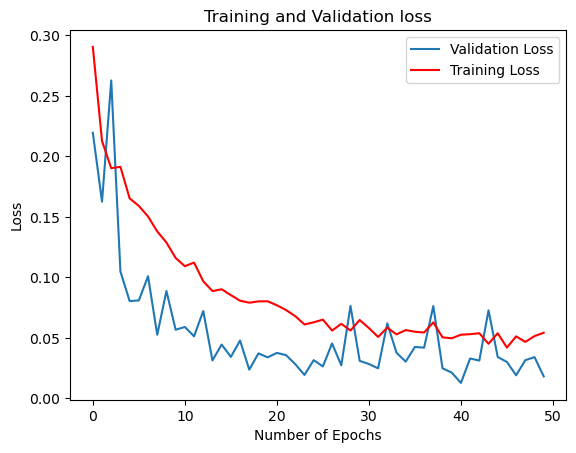

In [18]:
from matplotlib import pyplot as plt
plt.plot(Train_model.history['val_loss'],label='Validation Loss')
plt.plot(Train_model.history['loss'],'r',label='Training Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title("Training and Validation loss")
plt.legend()
plt.show()

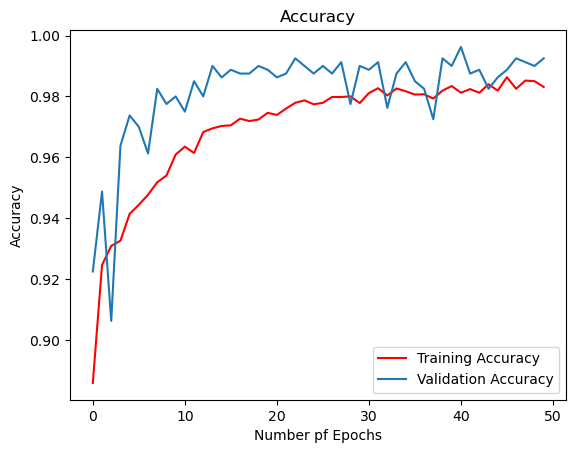

In [19]:
plt.plot(Train_model.history['accuracy'],'r',label='Training Accuracy')
plt.plot(Train_model.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Number pf Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()

# References

1. https://www.kaggle.com/code/tilasousa/face-mask-detection-using-keras-cnn
2. https://www.kaggle.com/code/chinmayaudupa/face-mask-detection-using-cnn-and-deep-learning